In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rivnet import reproject_arr_to_match_profile, reproject_profile_to_new_crs, get_graph_from_edge_dataframe
from pathlib import Path
import glob
from tqdm import tqdm
from skimage.color import label2rgb
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.lines import Line2D
import geopandas as gpd
from rivnet.plot import get_extent, make_map, rand_cmap
from srspy import get_cropped_profile
import networkx as nx
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.warp import transform
import scipy.ndimage as nd


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', family='serif', size=20)
plt.rcParams["text.usetex"] =True

# Load Data

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir_4326 = Path(f'{products_for_map_dir}_4326')


In [3]:
plot_dir = Path('plots')
plots_for_maps_dir = plot_dir/f'{map_name}'
plots_for_maps_dir.mkdir(exist_ok=True, parents=True)

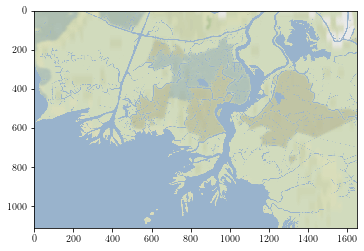

In [4]:
with rasterio.open(products_for_map_dir_4326/f'{map_name}.tif') as ds:
    arr = ds.read().transpose([1, 2, 0])[..., :3]
    profile = ds.profile
plt.imshow(arr)

In [5]:
with rasterio.open(products_for_map_dir_4326/'segments.tif') as ds:
    segments = label2rgb(ds.read(1), 
                         bg_label=0, 
                        )

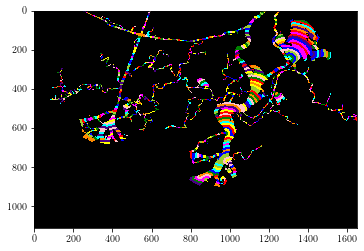

In [6]:
plt.imshow(segments)

In [7]:
with rasterio.open(products_for_map_dir_4326/'distance.tif') as ds:
    distance = ds.read(1)

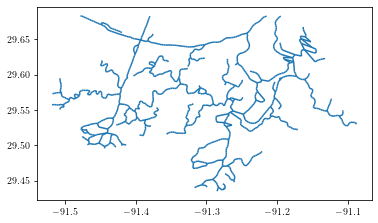

In [8]:
edges = gpd.read_file(products_for_map_dir/'rivnet_edges.geojson').to_crs({'init':'epsg:4326'})
edges.plot()

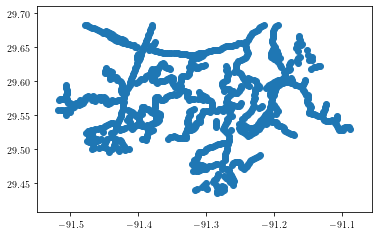

In [9]:
nodes = gpd.read_file(products_for_map_dir/'rivnet_nodes.geojson').to_crs({'init':'epsg:4326'})
nodes.plot()

In [10]:
with rasterio.open(products_for_map_dir_4326/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(products_for_map_dir_4326/'water_mask.tif') as ds:
    water_mask = ds.read(1)

# Plot

The extents here are specific to [`cartopy`](https://scitools.org.uk/cartopy/docs/latest/).

In [11]:
extent = get_extent(profile['transform'], profile['width'], profile['height'])
# xmin, xmax, ymax, ymin
extent

[-91.54444517680001,
 -91.08583406202001,
 29.683333570800002,
 29.374444679440003]

In [12]:
ocean_layer = ocean_mask.astype(dtype=float)
ocean_layer[~ocean_mask.astype(bool)] = np.nan

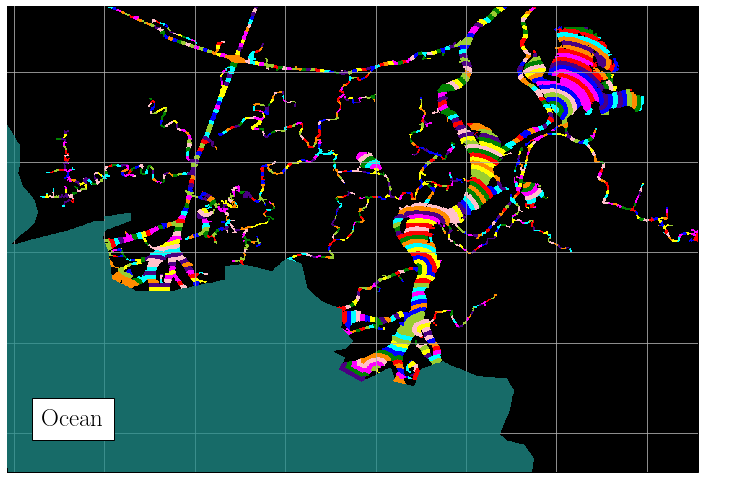

In [13]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 9),
                   labels=False
                   )
ax.set_extent(extent, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857)

ax.imshow(segments, 
             alpha=1, 
             zorder=2, 
             extent=extent,
             transform=ccrs.PlateCarree())



ax.imshow(ocean_layer, 
          alpha=.75, 
          zorder=3, 
          extent=extent,
          vmin=0, vmax=2,
          transform=ccrs.PlateCarree())

width = np.abs(extent[0] - extent[1])
height = np.abs(extent[2] - extent[3])
t = plt.text(extent[0] + .05 * width, 
             extent[3] + .1 * height, 
             r"Ocean", 
             c='black',
             size=25,
             zorder=4)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black', pad=10))

# Source: https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy 
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
cbar_ax = fig.add_axes([.92, 0.2, 0.025, .65])
cbar_ax.axis('off')

plt.savefig(plots_for_maps_dir/'segments.png')

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


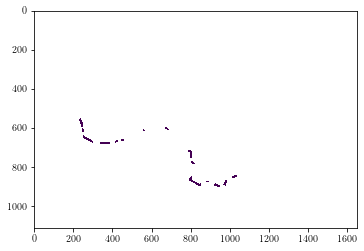

In [14]:
interface = (distance.copy() < 200)
interface = nd.binary_dilation(interface.astype(int), iterations=2).astype(float)
interface[~(interface >0)] = np.nan
plt.imshow(interface)

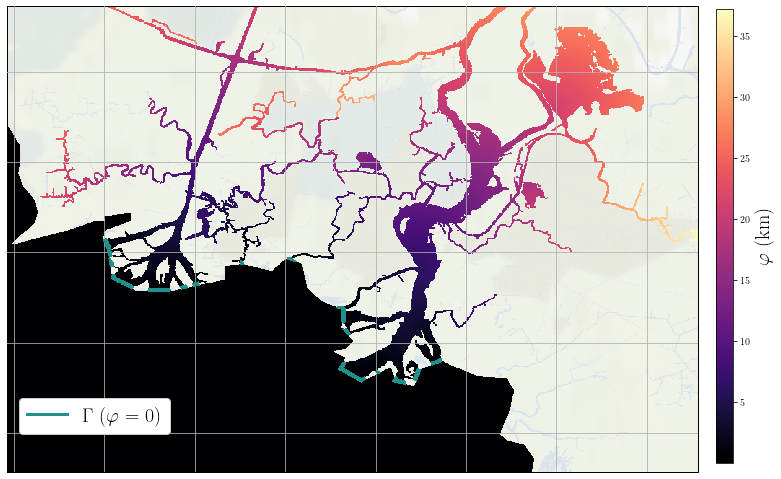

In [15]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 9),
                   labels=False
                   )
ax.set_extent(extent, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857)

im = ax.imshow(distance/1_000, 
             alpha=1, 
             zorder=2, 
             extent=extent,
             transform=ccrs.PlateCarree(), cmap='magma')

ax.imshow(arr, 
             alpha=.35, 
             zorder=1, 
             extent=extent,
             transform=ccrs.PlateCarree())
ax.imshow(ocean_layer, 
          alpha=1, 
          zorder=2, 
          extent=extent,
          vmin=1, vmax=2,
          cmap='magma',
          transform=ccrs.PlateCarree())


ax.imshow(interface , 
          alpha=1, 
          zorder=3, 
          extent=extent,
          vmin=0, vmax=2,
          cmap='viridis',
          transform=ccrs.PlateCarree())

# width = np.abs(extent[0] - extent[1])
# height = np.abs(extent[2] - extent[3])
# t = plt.text(extent[0] + .05 * width, 
#              extent[3] + .1 * height, 
#              r"$\varphi$ = 0", 
#              c='black',
#              size=25,
#              zorder=5)
# t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black', pad=10))


fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
cbar_ax = fig.add_axes([.92, 0.18, 0.02, .7])
plt.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar_ax.set_ylabel(r'$\varphi$ (km)', fontsize=20)


cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color=scalarMap.to_rgba(1),
                          label=r'$\Gamma$ ($\varphi=0$)',
                          linewidth=3,
                          markersize=10)]
ax.legend(handles=legend_elements,
          #loc='lower left',
          bbox_to_anchor=(.25, .18), 
          fontsize=20,  
          framealpha=1)


plt.savefig(plots_for_maps_dir/'distance.png')

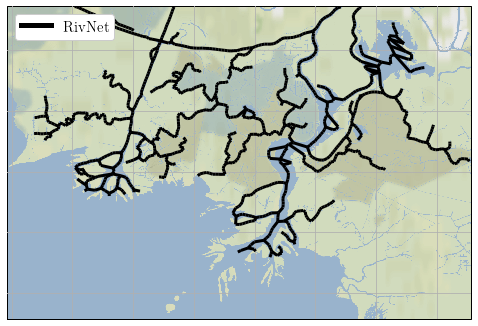

In [16]:
legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='black',
                          label='RivNet',
                          linewidth=5,
                          markersize=10)]

fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(8.5, 5.75),
                   labels=False
                   )
ax.set_extent(extent, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857))


ax.add_geometries(edges.geometry.values, 
                  edgecolor='black',
                  linewidth=3,
                  zorder = 3,
                  crs=ccrs.PlateCarree(),#ccrs.AzimuthalEquidistant(),#fig, ax = make_map(projection=ccrs.epsg(3857),
                 )

ax.imshow(arr, 
             alpha=1, 
             zorder=1, 
             extent=extent,
             transform=ccrs.PlateCarree())
ax.legend(handles=legend_elements, loc='upper left', fontsize=15, framealpha=1)

In [17]:
M = 3
labels = ['Land', 'Inland Water ($\Omega$)', 'Ocean']
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=(M-1))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          alpha=alpha,
                          markersize=10) for alpha, k in zip([1, 1, .75], range(M))]


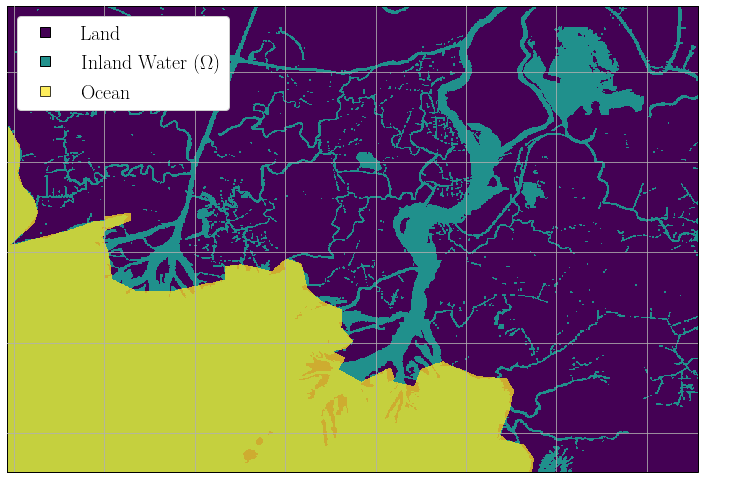

In [18]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(12, 9),
                   labels=False
                   )
ax.set_extent(extent, crs=ccrs.PlateCarree())


ax.imshow(water_mask, alpha=1, 
             zorder=1, 
             extent=extent,
             transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))


ax.imshow(ocean_layer, 
          zorder=1, 
          extent=extent,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmin=0, vmax=1, alpha=.75)
ax.legend(handles=legend_elements, loc='upper left', fontsize=20,  framealpha=1)


fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
cbar_ax = fig.add_axes([.92, 0.2, 0.025, .65])
cbar_ax.axis('off')


plt.savefig(plots_for_maps_dir/'landcover_init.png')

# Cropped for River Network

In [19]:
sy = np.s_[200:1000]
sx = np.s_[600:1350]

profile_cropped = get_cropped_profile(profile, sx, sy)

extent_c = get_extent(profile_cropped['transform'], profile_cropped['width'], profile_cropped['height'])
edges_c = edges.cx[extent_c[0]: extent_c[1], extent_c[3]: extent_c[2]].copy()
nodes_c = nodes.cx[extent_c[0]: extent_c[1], extent_c[3]: extent_c[2]].copy()

arr_c = arr[sy, sx]
ocean_layer_c = ocean_layer[sy, sx]
water_mask_c = water_mask[sy, sx]
extent

[-91.54444517680001,
 -91.08583406202001,
 29.683333570800002,
 29.374444679440003]

In [20]:
H = get_graph_from_edge_dataframe(edges_c, directed=True)
type(H), len(H), list(H.nodes())[0]

(networkx.classes.digraph.DiGraph,
 537,
 (-91.33604484631668, 29.586943763489742))

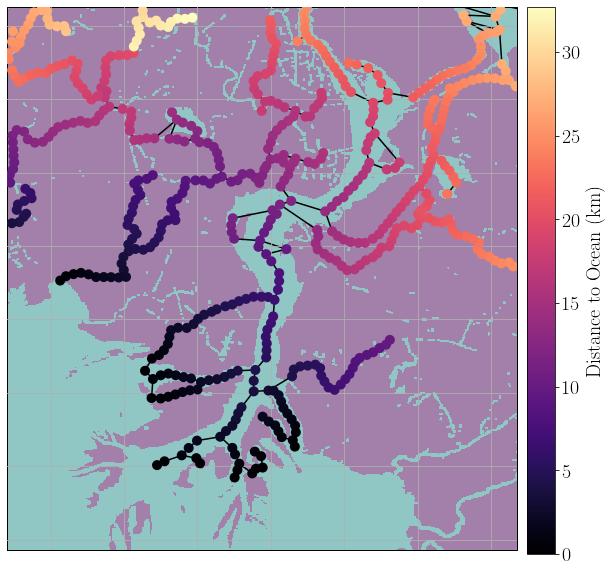

In [21]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(10, 10),
                   labels=False
                   )
plt.rc('font', family='serif', size=20)

ax.set_extent(extent_c, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857))

edges_c.plot(color='black', ax=ax, alpha=1,zorder=2)
nodes_c['km_to_coast'] = (nodes_c.meters_to_interface.values) / 1_000
nodes_c.plot(column='km_to_coast', ax=ax, cmap='magma', zorder=3, linewidth=4)



ax.imshow(water_mask_c, alpha=.5, 
          zorder=1, 
          extent=extent_c,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))




cax = fig.add_axes([0.88, 0.12, 0.04, 0.76])
vmin = nodes_c.km_to_coast.min()
vmax = nodes_c.km_to_coast.max()
sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

fig.colorbar(sm, cax=cax)
cax.set_ylabel('Distance to Ocean (km)', fontsize=20)
plt.savefig(plots_for_maps_dir/'cropped_node_dist.png')

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


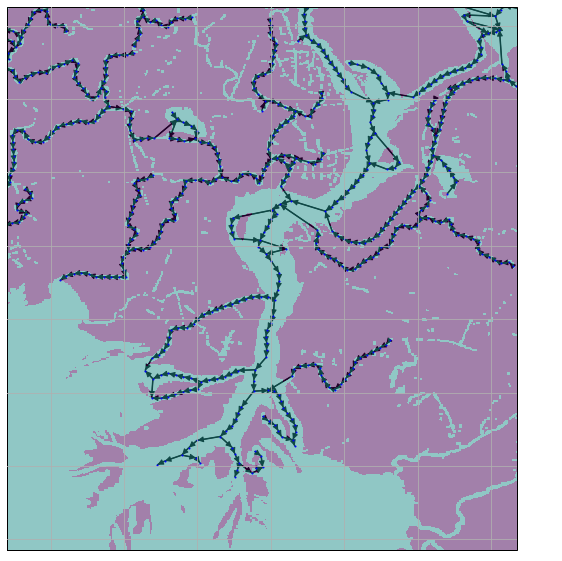

In [22]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(10, 10),
                   labels=False
                   )
ax.set_extent(extent_c, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857))

edges_c.plot(color='black', ax=ax, zorder=1)

ax.imshow(water_mask_c, alpha=.5, 
          zorder=1, 
          extent=extent_c,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))




pos = {node: node for node in H.nodes()}
nx.draw(H, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=12,
        ax=ax,
        node_color='blue',
        edgecolor=(0, 0, 0, 0))

ax.axis('on')
cax = fig.add_axes([0.88, 0.12, 0.04, 0.76])
cax.axis('off')
plt.savefig(plots_for_maps_dir/'cropped_net_dir.png')

In [23]:
N = edges_c.segment_id.max()
cmap = rand_cmap(N, verbose=False, type='bright')

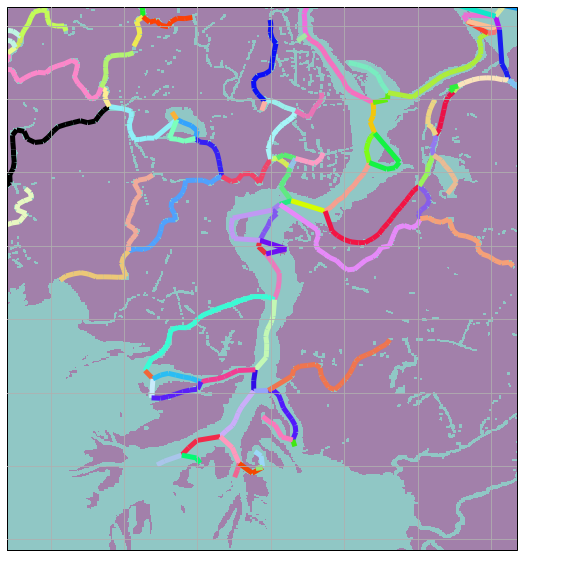

In [24]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(10, 10),
                   labels=False
                   )
ax.set_extent(extent_c, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857))

edges_c.plot(column='segment_id',cmap=cmap, ax=ax, zorder=2, categorical=True, linewidth=5)


ax.imshow(water_mask_c, alpha=.5, 
          zorder=1, 
          extent=extent_c,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))

cax = fig.add_axes([0.88, 0.12, 0.04, 0.76])
cax.axis('off')
plt.savefig(plots_for_maps_dir/'cropped_junction_segments.png')

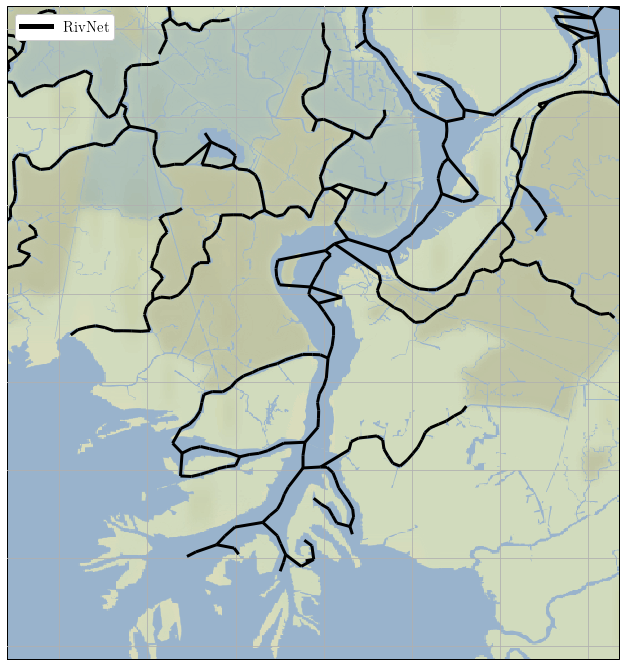

In [25]:
legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='black',
                          label='RivNet',
                          linewidth=5,
                          #markerfacecolor=scalarMap.to_rgba(k),
                          #markeredgecolor='black',
                          #edgecolor='black',
                          markersize=10)]

fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(15, 12),
                   labels=False
                   )
ax.set_extent(extent_c, crs=ccrs.PlateCarree())#[extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.epsg(3857))


ax.add_geometries(edges_c.geometry.values, 
                  edgecolor='black',
                  linewidth=3,
                  zorder = 3,
                  crs=ccrs.PlateCarree(),#ccrs.AzimuthalEquidistant(),#fig, ax = make_map(projection=ccrs.epsg(3857),
                 )

ax.imshow(arr_c, 
             alpha=1, 
             zorder=1, 
             extent=extent_c,
             transform=ccrs.PlateCarree())
ax.legend(handles=legend_elements, loc='upper left', fontsize=15, framealpha=1)
